# Image Augmentation


In [ ]:
# Augmentation
import os
import random
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- Configuration ---
# Set the path to your dataset folder in Google Drive
base_dataset_path = '/content/drive/MyDrive/Thesis/dataset' # <-- IMPORTANT: Check this path is correct

# Define the folders for each class
class_folders = {
    'acnes': 'acnes',
    'hyperpigmentation': 'hyperpigmentation',
    'Nail_psoriasis': 'Nail_psoriasis',
    'SJS-TEN': 'SJS-TEN',
    'Vitiligo': 'Vitiligo' # <-- Double-check this name matches your folder exactly
}

# The target number of images per class
target_image_count = 2000

# --- Augmentation Setup ---
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# --- Main Loop ---
for class_name, folder_name in class_folders.items():
    folder_path = os.path.join(base_dataset_path, folder_name)

    # --- ⭐️ ERROR FIX: Check if the folder exists ---
    if not os.path.isdir(folder_path):
        print(f"🚨 ERROR: Directory not found for class '{class_name}': {folder_path}. Skipping.")
        continue

    # Get the list of all images in the folder
    images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    num_images = len(images)

    print(f"\nProcessing '{class_name}': Found {num_images} images.")

    # --- Logic to Increase, Decrease, or Skip ---
    if num_images < target_image_count:
        # --- AUGMENTATION (INCREASE) LOGIC ---
        num_to_generate = target_image_count - num_images
        print(f"Augmenting '{class_name}': Generating {num_to_generate} new images...")

        # Select random images from the folder to augment
        images_to_augment = random.choices(images, k=num_to_generate)

        for image_name in images_to_augment:
            image_path = os.path.join(folder_path, image_name)
            try:
                img = Image.open(image_path).convert('RGB')
                img = img.resize((224, 224))
                x = np.array(img)
                x = x.reshape((1,) + x.shape)

                # Generate one augmented image
                for batch in datagen.flow(x, batch_size=1):
                    augmented_image = Image.fromarray(batch[0].astype('uint8'))
                    new_image_name = f"aug_{random.randint(10000, 99999)}_{image_name}"
                    augmented_image.save(os.path.join(folder_path, new_image_name))
                    break # Stop after one is generated
            except Exception as e:
                print(f"Could not process image {image_name}. Error: {e}")

    elif num_images > target_image_count:
        # --- ⭐️ NEW: DECREASE LOGIC ---
        num_to_delete = num_images - target_image_count
        print(f"Decreasing '{class_name}': Randomly deleting {num_to_delete} images...")

        # Randomly select images to delete
        images_to_delete = random.sample(images, num_to_delete)

        for image_name in images_to_delete:
            file_to_delete_path = os.path.join(folder_path, image_name)
            try:
                os.remove(file_to_delete_path)
            except Exception as e:
                print(f"Could not delete image {image_name}. Error: {e}")

    else: # num_images == target_image_count
        print(f"'{class_name}' already has {target_image_count} images. No action needed.")


print("\nProcessing complete! ✅")



Processing 'acnes': Found 1148 images.
Augmenting 'acnes': Generating 852 new images...

Processing 'hyperpigmentation': Found 700 images.
Augmenting 'hyperpigmentation': Generating 1300 new images...

Processing 'Nail_psoriasis': Found 2520 images.
Decreasing 'Nail_psoriasis': Randomly deleting 520 images...

Processing 'SJS-TEN': Found 3164 images.
Decreasing 'SJS-TEN': Randomly deleting 1164 images...

Processing 'Vitiligo': Found 2016 images.
Decreasing 'Vitiligo': Randomly deleting 16 images...

Processing complete! ✅


# Split Dataset

In [ ]:
import os
import random
import shutil

# --- Configuration ---
# Path to your balanced dataset (where each class has 2000 images)
source_dataset_path = '/content/drive/MyDrive/Thesis/dataset' # <-- IMPORTANT: Path to your processed dataset

# Path where the new split dataset will be created
output_dataset_path = '/content/drive/MyDrive/Thesis/Split_Dataset'

# Define the split ratios
# 70% for training, 15% for validation, 15% for testing
split_ratios = (0.7, 0.15, 0.15)

# --- Main Splitting Logic ---
print("Starting dataset split...")

# Create the main output directories (train, validation, test)
if os.path.exists(output_dataset_path):
    shutil.rmtree(output_dataset_path) # Remove old directory to ensure a clean split
    print(f"Removed existing directory at: {output_dataset_path}")

train_dir = os.path.join(output_dataset_path, 'train')
validation_dir = os.path.join(output_dataset_path, 'validation')
test_dir = os.path.join(output_dataset_path, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get the list of class folders from the source directory
class_names = [d for d in os.listdir(source_dataset_path) if os.path.isdir(os.path.join(source_dataset_path, d))]

# Loop through each class folder
for class_name in class_names:
    print(f"\nProcessing class: {class_name}")

    # Create class-specific subdirectories in train, validation, and test folders
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Get all image file names for the current class
    source_class_dir = os.path.join(source_dataset_path, class_name)
    all_files = [f for f in os.listdir(source_class_dir) if os.path.isfile(os.path.join(source_class_dir, f))]

    # Shuffle the files randomly for an unbiased split
    random.shuffle(all_files)

    # Calculate split indices
    total_files = len(all_files)
    train_end = int(total_files * split_ratios[0])
    validation_end = train_end + int(total_files * split_ratios[1])

    # Slice the list of files into the three sets
    train_files = all_files[:train_end]
    validation_files = all_files[train_end:validation_end]
    test_files = all_files[validation_end:]

    # --- Function to copy files ---
    def copy_files(files, source_dir, dest_dir):
        for f in files:
            shutil.copy(os.path.join(source_dir, f), os.path.join(dest_dir, f))

    # Copy files to their new destination
    copy_files(train_files, source_class_dir, os.path.join(train_dir, class_name))
    copy_files(validation_files, source_class_dir, os.path.join(validation_dir, class_name))
    copy_files(test_files, source_class_dir, os.path.join(test_dir, class_name))

    print(f"  - Training set:   {len(train_files)} images")
    print(f"  - Validation set: {len(validation_files)} images")
    print(f"  - Testing set:    {len(test_files)} images")

print("\nDataset splitting complete! ✅")

Starting dataset split...
Removed existing directory at: /content/drive/MyDrive/Thesis/Split_Dataset

Processing class: acnes
  - Training set:   1400 images
  - Validation set: 300 images
  - Testing set:    300 images

Processing class: SJS-TEN
  - Training set:   1400 images
  - Validation set: 300 images
  - Testing set:    300 images

Processing class: hyperpigmentation
  - Training set:   1400 images
  - Validation set: 300 images
  - Testing set:    300 images

Processing class: Vitiligo
  - Training set:   1400 images
  - Validation set: 300 images
  - Testing set:    300 images

Processing class: Nail_psoriasis
  - Training set:   1400 images
  - Validation set: 300 images
  - Testing set:    300 images

Dataset splitting complete! ✅


# Model Training

## EfficientNet - B0

Found 7000 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.
Found 5 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Starting Initial Training (Feature Extraction) ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.4881 - loss: 1.2557 - val_accuracy: 0.8073 - val_loss: 0.6090
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.7634 - loss: 0.6760 - val_accuracy: 0.8493 - val_loss: 0.4828
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.7920 - loss: 0.5678 - val_accuracy: 0.8687 - val_loss: 0.4179
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.8254 - loss: 0.5107 - val_accuracy: 0.8753 - val_loss: 0.3840
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.8241 - loss: 0.4830 - val_accuracy: 0.8873 - val_loss: 0.3567
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 110s 994ms/step - accuracy: 0.8405 - loss: 0.4591 - val_accuracy: 0.8893 - val_loss: 0.3510
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.8327 - loss: 0.4627 - val_accuracy: 0.9027 - val_loss: 0.3220
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.8446 - loss: 0.4288 - val_a

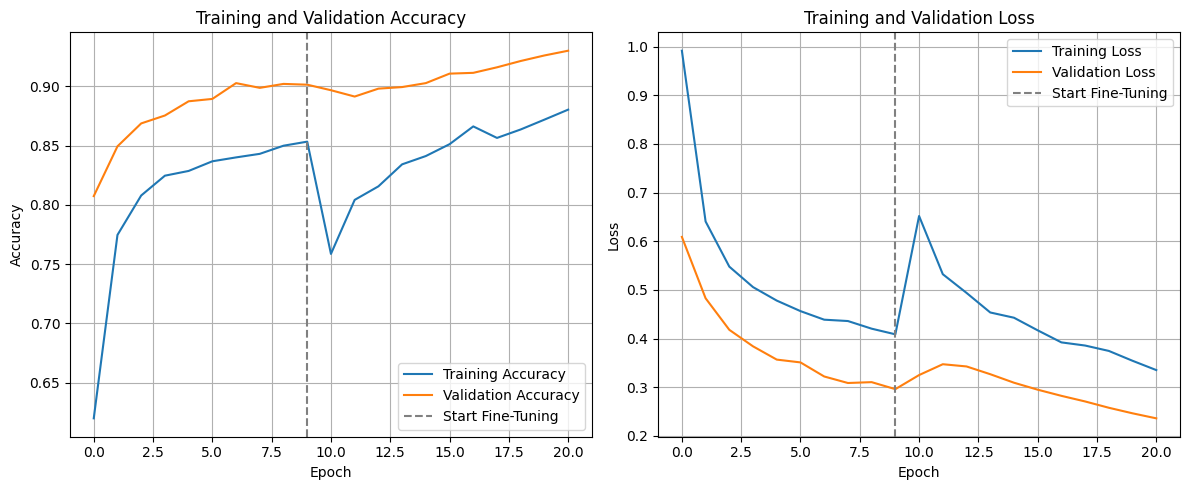

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os

# --- 1. Configuration and Setup ---

# Define paths to your split dataset
base_dir = '/content/drive/MyDrive/Thesis/Split_Dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Model parameters
# EfficientNetB0 default input size is 224x224
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64 # Adjust based on your GPU memory (16, 64)
INITIAL_EPOCHS = 10
FINE_TUNE_EPOCHS = 10
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

# --- 2. Data Loading and Preprocessing ---

# Create ImageDataGenerators with EfficientNet-specific preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and Test generators only need preprocessing
validation_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

# Create data generators from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)

# Get the number of classes
num_classes = train_generator.num_classes
print(f"Found {num_classes} classes.")

# --- 3. Model Building (Transfer Learning with EfficientNetB0) ---

# Load the EfficientNetB0 base model, pre-trained on ImageNet
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base model layers
base_model.trainable = False

# Create our custom classifier head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x) # Use Dropout for regularization
x = Dense(num_classes, activation='softmax')(x) # Final output layer

# Combine the base model and our custom head
model = Model(inputs=base_model.input, outputs=x)

# --- 4. Compile and Train (Feature Extraction Phase) ---
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("\n--- Starting Initial Training (Feature Extraction) ---")
history = model.fit(
    train_generator,
    epochs=INITIAL_EPOCHS,
    validation_data=validation_generator
)

# --- 5. Fine-Tuning Phase ---
print("\n--- Starting Fine-Tuning ---")

# Unfreeze the base model
base_model.trainable = True

# Fine-tune from this layer onwards. A good rule of thumb for EfficientNet
# is to unfreeze the top 20-30 layers.
fine_tune_at = -30

# Freeze all layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Re-compile the model with a very low learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Continue training the model
history_fine = model.fit(
    train_generator,
    epochs=TOTAL_EPOCHS,
    initial_epoch=history.epoch[-1],
    validation_data=validation_generator
)

# --- 6. Final Evaluation on the Test Set ---
print("\n--- Evaluating Model on Test Data ---")
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# --- 7. Plotting Training History ---
# Combine the history from both training phases
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

# Create plots
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(INITIAL_EPOCHS - 1, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(INITIAL_EPOCHS - 1, color='gray', linestyle='--', label='Start Fine-Tuning')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Confusion Matrix

24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 528ms/step

## Classification Report ##

                   precision    recall  f1-score   support

   Nail_psoriasis       0.95      0.98      0.96       300
          SJS-TEN       0.91      0.89      0.90       300
         Vitiligo       0.89      0.94      0.91       300
            acnes       0.94      0.96      0.95       300
hyperpigmentation       0.97      0.89      0.93       300

         accuracy                           0.93      1500
        macro avg       0.93      0.93      0.93      1500
     weighted avg       0.93      0.93      0.93      1500


## Confusion Matrix ##



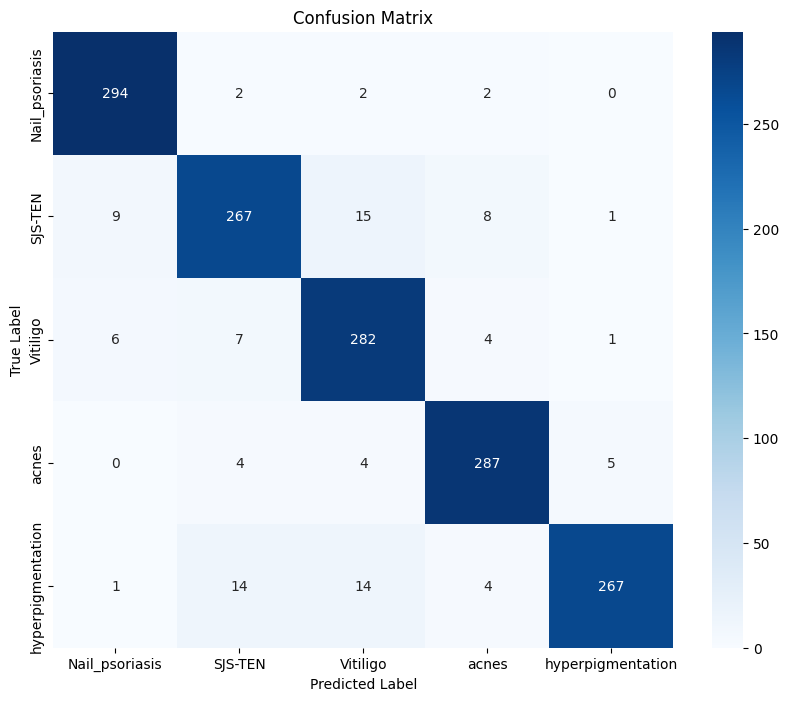

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Get Predictions and True Labels ---

# Ensure the test generator is not shuffling the data
test_generator.reset()

# Predict the output for the test set
# The model.predict() function will return the probability for each class
y_pred_probs = model.predict(
    test_generator,
    # FIX: Convert the result to an integer
    steps=int(np.ceil(test_generator.samples / test_generator.batch_size))
)

# Convert the probabilities to a single predicted class index
# np.argmax finds the index of the highest probability
y_pred = np.argmax(y_pred_probs, axis=1)

# Get the true labels from the generator
y_true = test_generator.classes

# Get the class names from the generator
class_names = list(test_generator.class_indices.keys())


# --- 2. Generate Classification Report ---
# This report includes precision, recall, and f1-score for each class

print("\n## Classification Report ##\n")
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


# --- 3. Plot Confusion Matrix ---

print("\n## Confusion Matrix ##\n")

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


**Copying drive to local**

In [1]:
import os
import shutil
from tqdm import tqdm

# Path to your dataset on Google Drive
drive_dataset_path = "/content/drive/MyDrive/Thesis/Split_Dataset"
# Path where you want to copy locally (Colab's fast storage)
local_dataset_path = "/content/dataset/Split_Dataset"

# Remove any old copy if exists
if os.path.exists(local_dataset_path):
    shutil.rmtree(local_dataset_path)

# Copy dataset from Drive to Colab local storage
print("Copying dataset from Drive to local storage...")
shutil.copytree(drive_dataset_path, local_dataset_path)

print("✅ Dataset copied to:", local_dataset_path)


Copying dataset from Drive to local storage...
✅ Dataset copied to: /content/dataset/Split_Dataset


## NASNet Mobile

Found 7000 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.
Found 5 classes.

--- Starting Initial Training (Feature Extraction) ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 764s 5s/step - accuracy: 0.4006 - loss: 1.4938 - val_accuracy: 0.7147 - val_loss: 0.8038
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 92s 838ms/step - accuracy: 0.6548 - loss: 0.8948 - val_accuracy: 0.7773 - val_loss: 0.6623
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 90s 816ms/step - accuracy: 0.6915 - loss: 0.7893 - val_accuracy: 0.7987 - val_loss: 0.5924
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 91s 825ms/step - accuracy: 0.7174 - loss: 0.7424 - val_accuracy: 0.8033 - val_loss: 0.5669
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 90s 817ms/step - accuracy: 0.7390 - loss: 0.6863 - val_accuracy: 0.8160 - val_loss: 0.5336
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 90s 823ms/step - accuracy: 0.7402 - loss: 0.6759 - val_accuracy: 0.8240 - val_loss: 0.5114
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 92s 841ms/step - accuracy: 0.7430 - loss: 0.6585 - val_accuracy: 0.8100 - val_loss: 0.5189
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 90s 821ms/step - accuracy: 0.7419 - loss: 0.6

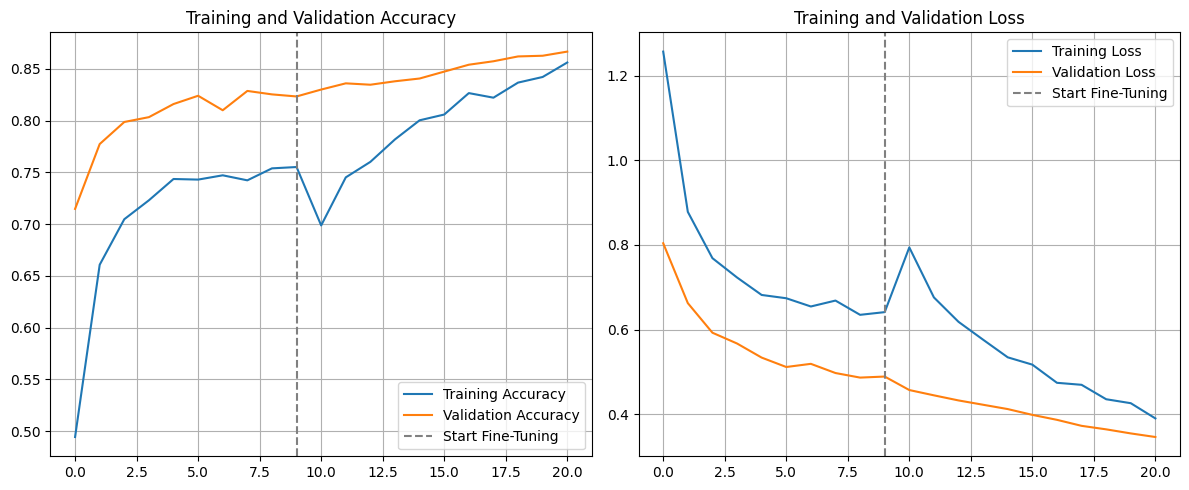

In [2]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import NASNetMobile

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

import os

# --- 1. SETUP FOR SPEED: MIXED PRECISION ---

tf.keras.mixed_precision.set_global_policy('mixed_float16')

# --- 2. Configuration and Setup ---

# Define paths to your split dataset

base_dir = '/content/dataset/Split_Dataset'

train_dir = os.path.join(base_dir, 'train')

validation_dir = os.path.join(base_dir, 'validation')

test_dir = os.path.join(base_dir, 'test')

# Model parameters

IMG_HEIGHT = 224

IMG_WIDTH = 224

BATCH_SIZE = 64 # Larger batch size for faster training

INITIAL_EPOCHS = 10

FINE_TUNE_EPOCHS = 10

TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

# --- 3. Data Loading and Preprocessing ---

# Create ImageDataGenerators with NASNet-specific preprocessing

train_datagen = ImageDataGenerator(

    preprocessing_function=tf.keras.applications.nasnet.preprocess_input,

    rotation_range=40,

    width_shift_range=0.2,

    height_shift_range=0.2,

    shear_range=0.2,

    zoom_range=0.2,

    horizontal_flip=True,

    fill_mode='nearest'

)

validation_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.nasnet.preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.nasnet.preprocess_input)

# Create data generators from directories

train_generator = train_datagen.flow_from_directory(

    train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='sparse')

validation_generator = validation_datagen.flow_from_directory(

    validation_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='sparse')

test_generator = test_datagen.flow_from_directory(

    test_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='sparse', shuffle=False)

num_classes = train_generator.num_classes

print(f"Found {num_classes} classes.")

# --- 4. Model Building (Transfer Learning with NASNetMobile) ---

# Load the NASNetMobile base model

base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base model

base_model.trainable = False

# Create our custom classifier head

x = base_model.output

x = GlobalAveragePooling2D()(x)

x = Dropout(0.5)(x)

# Set the final layer's dtype to float32 for numerical stability

predictions = Dense(num_classes, activation='softmax', dtype='float32')(x)

# Combine the base model and our custom head

model = Model(inputs=base_model.input, outputs=predictions)

# --- 5. Compile and Train (Feature Extraction) ---

# Wrap the optimizer in a LossScaleOptimizer for mixed precision

optimizer = tf.keras.mixed_precision.LossScaleOptimizer(Adam(learning_rate=0.001))

model.compile(optimizer=optimizer,

              loss='sparse_categorical_crossentropy',

              metrics=['accuracy'])

print("\n--- Starting Initial Training (Feature Extraction) ---")

history = model.fit(

    train_generator,

    epochs=INITIAL_EPOCHS,

    validation_data=validation_generator

)

# --- 6. Fine-Tuning Phase ---

print("\n--- Starting Fine-Tuning ---")

base_model.trainable = True

# NASNetMobile has 769 layers. Let's unfreeze from layer 600 onwards.

fine_tune_at = 600

for layer in base_model.layers[:fine_tune_at]:

    layer.trainable = False

# Re-compile with the LossScaleOptimizer for fine-tuning

optimizer_fine = tf.keras.mixed_precision.LossScaleOptimizer(Adam(learning_rate=1e-5))

model.compile(optimizer=optimizer_fine,

              loss='sparse_categorical_crossentropy',

              metrics=['accuracy'])

history_fine = model.fit(

    train_generator,

    epochs=TOTAL_EPOCHS,

    initial_epoch=history.epoch[-1],

    validation_data=validation_generator

)

# --- 7. Final Evaluation ---

print("\n--- Evaluating Model on Test Data ---")

test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {test_accuracy*100:.2f}%")

print(f"Test Loss: {test_loss:.4f}")

# --- 8. Plotting History ---

acc = history.history['accuracy'] + history_fine.history['accuracy']

val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']

val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)

plt.plot(acc, label='Training Accuracy')

plt.plot(val_acc, label='Validation Accuracy')

plt.axvline(INITIAL_EPOCHS - 1, color='gray', linestyle='--', label='Start Fine-Tuning')

plt.title('Training and Validation Accuracy')

plt.legend()

plt.grid(True)

plt.subplot(1, 2, 2)

plt.plot(loss, label='Training Loss')

plt.plot(val_loss, label='Validation Loss')

plt.axvline(INITIAL_EPOCHS - 1, color='gray', linestyle='--', label='Start Fine-Tuning')

plt.title('Training and Validation Loss')

plt.legend()

plt.grid(True)

plt.tight_layout()

plt.show()

### Confusion Matrix

In [6]:
# COMPLETE CONFUSION MATRIX CODE - INCLUDING ALL NECESSARY SETUP
# Run this code in the same cell/session where your model is trained,
# OR run this complete version that recreates the test generator

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# --- SETUP (Only run if test_generator is not already defined) ---
# If you get NameError, uncomment and modify these paths to match your setup:

# Configuration (Update these paths to match your dataset)
base_dir = '/content/dataset/Split_Dataset'  # UPDATE THIS PATH
test_dir = os.path.join(base_dir, 'test')
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64

# Recreate test generator if not already defined
try:
    # Check if test_generator exists
    test_generator.class_indices
    print("✓ test_generator found and ready to use")
except NameError:
    print("⚠ test_generator not found, creating new one...")

    # Create test data generator
    test_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.nasnet.preprocess_input
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=False  # Important: keep False for confusion matrix
    )
    print("✓ test_generator created successfully")

# Check if model exists
try:
    model.summary
    print("✓ Model found and ready to use")
except NameError:
    print("❌ ERROR: 'model' not found. Please run your training code first!")
    print("Make sure your NASNet Mobile model is trained and available as 'model'")

# --- CONFUSION MATRIX GENERATION ---
print("\n" + "="*60)
print("GENERATING CONFUSION MATRIX FOR NASNet MOBILE")
print("="*60)

# Reset test generator to start from beginning
test_generator.reset()

# Get predictions
print("\n📊 Generating predictions on test set...")
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels and class names
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print(f"\n📈 Test Set Information:")
print(f"   Number of test samples: {len(true_classes)}")
print(f"   Number of predictions: {len(predicted_classes)}")
print(f"   Number of classes: {len(class_labels)}")
print(f"   Class labels: {class_labels}")

# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
print(f"\n✅ Confusion Matrix Generated - Shape: {cm.shape}")

# --- 1. RAW CONFUSION MATRIX VISUALIZATION ---
plt.figure(figsize=(12, 10))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels,
            cbar_kws={'label': 'Number of Samples'},
            square=True)
plt.title('Confusion Matrix - NASNet Mobile\nSkin Disease Classification',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Labels', fontsize=14, fontweight='bold')
plt.ylabel('True Labels', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- 2. NORMALIZED CONFUSION MATRIX ---
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized,
            annot=True,
            fmt='.2f',
            cmap='Greens',
            xticklabels=class_labels,
            yticklabels=class_labels,
            cbar_kws={'label': 'Percentage'},
            square=True,
            vmin=0, vmax=1)
plt.title('Normalized Confusion Matrix - NASNet Mobile\nSkin Disease Classification',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Labels', fontsize=14, fontweight='bold')
plt.ylabel('True Labels', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- 3. CLASSIFICATION REPORT ---
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT")
print("="*60)
report = classification_report(true_classes, predicted_classes,
                             target_names=class_labels,
                             digits=4)
print(report)

# --- 4. PER-CLASS METRICS TABLE ---
precision, recall, f1_score, support = precision_recall_fscore_support(
    true_classes, predicted_classes, average=None)

metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1_score,
    'Support': support
})

print("\n📊 PER-CLASS PERFORMANCE METRICS:")
print("-" * 70)
print(metrics_df.round(4).to_string(index=False))

# --- 5. OVERALL PERFORMANCE SUMMARY ---
overall_accuracy = accuracy_score(true_classes, predicted_classes)
macro_avg_precision = np.mean(precision)
macro_avg_recall = np.mean(recall)
macro_avg_f1 = np.mean(f1_score)

print(f"\n🎯 OVERALL PERFORMANCE SUMMARY:")
print("-" * 40)
print(f"Overall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
print(f"Macro Avg Precision: {macro_avg_precision:.4f}")
print(f"Macro Avg Recall: {macro_avg_recall:.4f}")
print(f"Macro Avg F1-Score: {macro_avg_f1:.4f}")

# --- 6. CLASS-WISE ACCURACY ---
print(f"\n📈 CLASS-WISE ACCURACY:")
print("-" * 35)
class_accuracies = cm.diagonal() / cm.sum(axis=1)
for i, (class_name, accuracy) in enumerate(zip(class_labels, class_accuracies)):
    print(f"{class_name:20}: {accuracy:.4f} ({accuracy*100:.2f}%)")

# --- 7. ERROR ANALYSIS - MOST CONFUSED CLASSES ---
print(f"\n❌ MOST CONFUSED CLASS PAIRS:")
print("-" * 35)
misclassifications = []
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        if i != j and cm[i][j] > 0:
            misclassifications.append((class_labels[i], class_labels[j], cm[i][j]))

# Sort by number of misclassifications
misclassifications.sort(key=lambda x: x[2], reverse=True)

if misclassifications:
    print("Top 5 most confused class pairs:")
    for i, (true_class, pred_class, count) in enumerate(misclassifications[:5]):
        percentage = (count / cm.sum()) * 100
        print(f"{i+1}. {true_class} → {pred_class}: {count} samples ({percentage:.1f}%)")
else:
    print("No misclassifications found (perfect classification!)")

# --- 8. SAVE RESULTS ---
print(f"\n💾 SAVING RESULTS:")
print("-" * 20)

# Save confusion matrix
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
cm_df.to_csv('confusion_matrix_nasnet.csv')
print("✓ Raw confusion matrix saved as 'confusion_matrix_nasnet.csv'")

# Save normalized confusion matrix
cm_norm_df = pd.DataFrame(cm_normalized, index=class_labels, columns=class_labels)
cm_norm_df.to_csv('confusion_matrix_normalized_nasnet.csv')
print("✓ Normalized confusion matrix saved as 'confusion_matrix_normalized_nasnet.csv'")

# Save detailed metrics
metrics_df.to_csv('per_class_metrics_nasnet.csv', index=False)
print("✓ Per-class metrics saved as 'per_class_metrics_nasnet.csv'")

# Save comprehensive report
with open('nasnet_classification_report.txt', 'w') as f:
    f.write("NASNet Mobile - Skin Disease Classification Report\n")
    f.write("="*55 + "\n\n")
    f.write(f"Dataset: 5-Class Skin Disease Classification\n")
    f.write(f"Model: NASNet Mobile\n")
    f.write(f"Test Samples: {len(true_classes)}\n\n")

    f.write(f"OVERALL PERFORMANCE:\n")
    f.write(f"Overall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)\n")
    f.write(f"Macro Avg Precision: {macro_avg_precision:.4f}\n")
    f.write(f"Macro Avg Recall: {macro_avg_recall:.4f}\n")
    f.write(f"Macro Avg F1-Score: {macro_avg_f1:.4f}\n\n")

    f.write("DETAILED CLASSIFICATION REPORT:\n")
    f.write(report)

    f.write(f"\n\nCLASS-WISE ACCURACY:\n")
    for class_name, accuracy in zip(class_labels, class_accuracies):
        f.write(f"{class_name}: {accuracy:.4f} ({accuracy*100:.2f}%)\n")

print("✓ Comprehensive report saved as 'nasnet_classification_report.txt'")

print(f"\n🎉 CONFUSION MATRIX ANALYSIS COMPLETE!")
print(f"Your NASNet Mobile achieved {overall_accuracy*100:.2f}% accuracy on the test set.")

# Display final accuracy assessment
if overall_accuracy >= 0.90:
    print("🏆 Excellent performance!")
elif overall_accuracy >= 0.80:
    print("👍 Good performance!")
elif overall_accuracy >= 0.70:
    print("⚠️  Moderate performance - consider model improvements")
else:
    print("❌ Low performance - significant improvements needed")

⚠ test_generator not found, creating new one...


FileNotFoundError: [Errno 2] No such file or directory: '/content/dataset/Split_Dataset/test'

### Confusion Matrix

In [ ]:
# COMPLETE CONFUSION MATRIX CODE - INCLUDING ALL NECESSARY SETUP
# Run this code in the same cell/session where your model is trained,
# OR run this complete version that recreates the test generator

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# --- SETUP (Only run if test_generator is not already defined) ---
# If you get NameError, uncomment and modify these paths to match your setup:

# Configuration (Update these paths to match your dataset)
base_dir = '/content/dataset/Split_Dataset'  # UPDATE THIS PATH
test_dir = os.path.join(base_dir, 'test')
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64

# Recreate test generator if not already defined
try:
    # Check if test_generator exists
    test_generator.class_indices
    print("✓ test_generator found and ready to use")
except NameError:
    print("⚠ test_generator not found, creating new one...")

    # Create test data generator
    test_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.nasnet.preprocess_input
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=False  # Important: keep False for confusion matrix
    )
    print("✓ test_generator created successfully")

# Check if model exists
try:
    model.summary
    print("✓ Model found and ready to use")
except NameError:
    print("❌ ERROR: 'model' not found. Please run your training code first!")
    print("Make sure your NASNet Mobile model is trained and available as 'model'")

# --- CONFUSION MATRIX GENERATION ---
print("\n" + "="*60)
print("GENERATING CONFUSION MATRIX FOR NASNet MOBILE")
print("="*60)

# Reset test generator to start from beginning
test_generator.reset()

# Get predictions
print("\n📊 Generating predictions on test set...")
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels and class names
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print(f"\n📈 Test Set Information:")
print(f"   Number of test samples: {len(true_classes)}")
print(f"   Number of predictions: {len(predicted_classes)}")
print(f"   Number of classes: {len(class_labels)}")
print(f"   Class labels: {class_labels}")

# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
print(f"\n✅ Confusion Matrix Generated - Shape: {cm.shape}")

# --- 1. RAW CONFUSION MATRIX VISUALIZATION ---
plt.figure(figsize=(12, 10))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels,
            cbar_kws={'label': 'Number of Samples'},
            square=True)
plt.title('Confusion Matrix - NASNet Mobile\nSkin Disease Classification',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Labels', fontsize=14, fontweight='bold')
plt.ylabel('True Labels', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- 2. NORMALIZED CONFUSION MATRIX ---
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized,
            annot=True,
            fmt='.2f',
            cmap='Greens',
            xticklabels=class_labels,
            yticklabels=class_labels,
            cbar_kws={'label': 'Percentage'},
            square=True,
            vmin=0, vmax=1)
plt.title('Normalized Confusion Matrix - NASNet Mobile\nSkin Disease Classification',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Labels', fontsize=14, fontweight='bold')
plt.ylabel('True Labels', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- 3. CLASSIFICATION REPORT ---
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT")
print("="*60)
report = classification_report(true_classes, predicted_classes,
                             target_names=class_labels,
                             digits=4)
print(report)

# --- 4. PER-CLASS METRICS TABLE ---
precision, recall, f1_score, support = precision_recall_fscore_support(
    true_classes, predicted_classes, average=None)

metrics_df = pd.DataFrame({
    'Class': class_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1_score,
    'Support': support
})

print("\n📊 PER-CLASS PERFORMANCE METRICS:")
print("-" * 70)
print(metrics_df.round(4).to_string(index=False))

# --- 5. OVERALL PERFORMANCE SUMMARY ---
overall_accuracy = accuracy_score(true_classes, predicted_classes)
macro_avg_precision = np.mean(precision)
macro_avg_recall = np.mean(recall)
macro_avg_f1 = np.mean(f1_score)

print(f"\n🎯 OVERALL PERFORMANCE SUMMARY:")
print("-" * 40)
print(f"Overall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
print(f"Macro Avg Precision: {macro_avg_precision:.4f}")
print(f"Macro Avg Recall: {macro_avg_recall:.4f}")
print(f"Macro Avg F1-Score: {macro_avg_f1:.4f}")

# --- 6. CLASS-WISE ACCURACY ---
print(f"\n📈 CLASS-WISE ACCURACY:")
print("-" * 35)
class_accuracies = cm.diagonal() / cm.sum(axis=1)
for i, (class_name, accuracy) in enumerate(zip(class_labels, class_accuracies)):
    print(f"{class_name:20}: {accuracy:.4f} ({accuracy*100:.2f}%)")

# --- 7. ERROR ANALYSIS - MOST CONFUSED CLASSES ---
print(f"\n❌ MOST CONFUSED CLASS PAIRS:")
print("-" * 35)
misclassifications = []
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        if i != j and cm[i][j] > 0:
            misclassifications.append((class_labels[i], class_labels[j], cm[i][j]))

# Sort by number of misclassifications
misclassifications.sort(key=lambda x: x[2], reverse=True)

if misclassifications:
    print("Top 5 most confused class pairs:")
    for i, (true_class, pred_class, count) in enumerate(misclassifications[:5]):
        percentage = (count / cm.sum()) * 100
        print(f"{i+1}. {true_class} → {pred_class}: {count} samples ({percentage:.1f}%)")
else:
    print("No misclassifications found (perfect classification!)")

# --- 8. SAVE RESULTS ---
print(f"\n💾 SAVING RESULTS:")
print("-" * 20)

# Save confusion matrix
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
cm_df.to_csv('confusion_matrix_nasnet.csv')
print("✓ Raw confusion matrix saved as 'confusion_matrix_nasnet.csv'")

# Save normalized confusion matrix
cm_norm_df = pd.DataFrame(cm_normalized, index=class_labels, columns=class_labels)
cm_norm_df.to_csv('confusion_matrix_normalized_nasnet.csv')
print("✓ Normalized confusion matrix saved as 'confusion_matrix_normalized_nasnet.csv'")

# Save detailed metrics
metrics_df.to_csv('per_class_metrics_nasnet.csv', index=False)
print("✓ Per-class metrics saved as 'per_class_metrics_nasnet.csv'")

# Save comprehensive report
with open('nasnet_classification_report.txt', 'w') as f:
    f.write("NASNet Mobile - Skin Disease Classification Report\n")
    f.write("="*55 + "\n\n")
    f.write(f"Dataset: 5-Class Skin Disease Classification\n")
    f.write(f"Model: NASNet Mobile\n")
    f.write(f"Test Samples: {len(true_classes)}\n\n")

    f.write(f"OVERALL PERFORMANCE:\n")
    f.write(f"Overall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)\n")
    f.write(f"Macro Avg Precision: {macro_avg_precision:.4f}\n")
    f.write(f"Macro Avg Recall: {macro_avg_recall:.4f}\n")
    f.write(f"Macro Avg F1-Score: {macro_avg_f1:.4f}\n\n")

    f.write("DETAILED CLASSIFICATION REPORT:\n")
    f.write(report)

    f.write(f"\n\nCLASS-WISE ACCURACY:\n")
    for class_name, accuracy in zip(class_labels, class_accuracies):
        f.write(f"{class_name}: {accuracy:.4f} ({accuracy*100:.2f}%)\n")

print("✓ Comprehensive report saved as 'nasnet_classification_report.txt'")

print(f"\n🎉 CONFUSION MATRIX ANALYSIS COMPLETE!")
print(f"Your NASNet Mobile achieved {overall_accuracy*100:.2f}% accuracy on the test set.")

# Display final accuracy assessment
if overall_accuracy >= 0.90:
    print("🏆 Excellent performance!")
elif overall_accuracy >= 0.80:
    print("👍 Good performance!")
elif overall_accuracy >= 0.70:
    print("⚠️  Moderate performance - consider model improvements")
else:
    print("❌ Low performance - significant improvements needed")

⚠ test_generator not found, creating new one...


FileNotFoundError: [Errno 2] No such file or directory: '/content/dataset/Split_Dataset/test'